# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#machine learning libs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#deep learning libs
#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
#setting up the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# West Dover Scraped Properties Data

This dataset contains records on properties for sale or sold in the West Dover, Vermont area in the last three years. West Dover, VT is known for its beautiful scenery during the Winter and Fall seasons, and many tourits visit during the Winter to enjoy skiing sports on the Mount Snow trail. This dataset contains **458** properties sold between **2020** and **2022**  

In [3]:
#read dataset from excel file
df = pd.read_excel(r'West_dover_apify.xlsx')

#filter on needed columns only
cols = ['abbreviatedAddress', 'address/city', 'address/zipcode', 'bathrooms', 'bedrooms',
'dateSoldString', 'daysOnZillow', 'description', 'favoriteCount' ,'hoaFee' , 'homeStatus', 'homeType', 'lastSoldPrice', 
'latitude', 'longitude', 'livingArea', 'lotSize', 'mortgageRates/thirtyYearFixedRate', 'pageViewCount', 'postingContact/name', 
'propertyTaxRate', 'taxHistory/0/value', 'yearBuilt']

#filter on needed columns
df1 = df.copy()
df1 = df1.loc[:,cols]

#removing for sale properties since the last sold price is only the price at which it was sold years ago and not the listed price
df1 = df1[~(df1['homeStatus']=='FOR_SALE')]

In [4]:
df.shape

(513, 758)

In [5]:
df1.head()

,abbreviatedAddress,address/city,address/zipcode,bathrooms,bedrooms,dateSoldString,daysOnZillow,description,favoriteCount,hoaFee,homeStatus,homeType,lastSoldPrice,latitude,longitude,livingArea,lotSize,mortgageRates/thirtyYearFixedRate,pageViewCount,postingContact/name,propertyTaxRate,taxHistory/0/value,yearBuilt
0,8E Deer Creek Road UNIT E,West Dover,5356,2.0,3.0,NaN,1.0,"3 Bedroom 2 bath, top level and a great price!...",17.0,NaN,RECENTLY_SOLD,CONDO,349000.0,42.962830,-72.889040,1024.0,NaN,5.418,300.0,Sheila Joyce-Albano,1.84,153000.0,1989.0
7,28A Crosstown Road,West Dover,5356,2.0,4.0,NaN,0.0,Spacious 3 bedroom plus loft townhome just dow...,1.0,NaN,RECENTLY_SOLD,CONDO,350000.0,42.974842,-72.890920,1696.0,NaN,5.418,42.0,Adam Palmiter,1.84,NaN,1986.0
9,202 Blue Brook Road,West Dover,5356,2.0,3.0,NaN,0.0,"A cozy, charming, well-kept 3 bedroom, 2 bath ...",3.0,NaN,RECENTLY_SOLD,SINGLE_FAMILY,329000.0,42.972470,-72.872090,1532.0,23087.0,5.418,152.0,Regina Perrotto,1.84,191460.0,1960.0
12,734 VT Route 100,Wilmington,5363,1.0,2.0,2022-07-06,65.0,So many potential uses for this versatile prop...,NaN,NaN,RECENTLY_SOLD,SINGLE_FAMILY,200000.0,42.910248,-72.845870,700.0,301870.0,5.774,NaN,Jacki Murano,1.84,95000.0,1977.0
13,12 Timberview Road,West Dover,5356,NaN,NaN,2022-09-01,8.0,1.3 acre lot in a quiet location not too far f...,NaN,NaN,RECENTLY_SOLD,LOT,11000.0,42.937630,-72.811356,NaN,57934.0,NaN,NaN,Chad Lackey,1.84,7900.0,NaN


<BarContainer object of 7 artists>

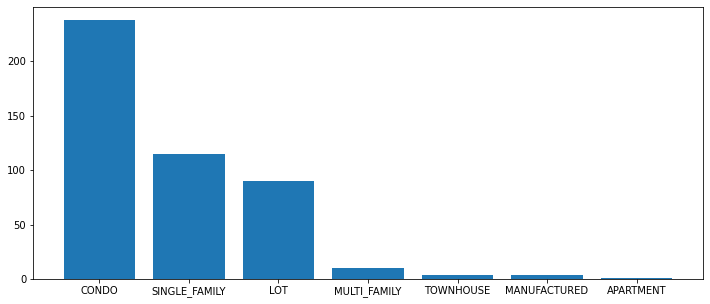

In [6]:
plt.figure(figsize=(12,5))
plt.bar(x= df1['homeType'].unique(), height =df1[['homeType']].value_counts())

In [7]:
df1.shape

(462, 23)

# Feature Engineering

In [8]:
###################### DATE TIME FEATURES #################################################################
df1.loc[:,'dateSoldString'] = pd.to_datetime(df1['dateSoldString'], format="%Y-%m-%d") #to date time format
df1['soldYear'] = df1['dateSoldString'].dt.year #get the year
df1['soldMonth'] = df1['dateSoldString'].dt.month #get the month
df1['totalRooms'] = df1['bedrooms'] + df1['bathrooms'] #add a new feature

#################### OTHER FEATURES ################################################################
df1['favoritePerView'] = df1['pageViewCount'] / df1['favoriteCount'] #add a new feature
df1['Age'] = 2022 - df1['yearBuilt'] #add a new feature
df1['Sqft/room'] = df1['livingArea']/df1['totalRooms']
df1['Price/Sqft'] = df1['lastSoldPrice']/df1['livingArea']

########################## LOCATION FEATURES ############################################
cluster_features = df1[['longitude', 'latitude']]
#scale features
minmaxscaler = StandardScaler()
transformed_features = minmaxscaler.fit_transform(cluster_features)
#run clustering algorithm
km = KMeans(init="k-means++", n_clusters=8, n_init=11, random_state=0 )
#fit the dataset to the algorithm
km.fit(transformed_features)
labels = km.labels_
km.labels_
df1['Location cluster'] = labels 
df1['Location cluster'] = df1['Location cluster'].astype('str')

In [9]:
################################ Vizulaizing the Clusters ###########################################################
mapbox_api_key = "pk.eyJ1IjoiaHVzc2Vpbm1vaGFtZWQiLCJhIjoiY2w1MXk3cWNhMDdpNzNqb2NiN3VoNDZycyJ9.ggqfCgSW64ZyD5JnXZ1QGA"
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# set mapbox key
px.set_mapbox_access_token(mapbox_api_key)
# create scatter plot
fig = px.scatter_mapbox(
    df1, 
    lat="latitude", 
    lon="longitude",
    color='Location cluster',
    hover_name='abbreviatedAddress',
    size='lastSoldPrice',
    zoom=13
)
# modify height to show all of (town specific)
fig.update_layout(
    height=800,
    width=900
)
fig.show()

# Data Exploration

#### What is the relationship between time sold and price per square foot? 
in west dover, vt there seems to be a positive relationship between the time at which a property was sold vs. the price per squarefoot.The median price/sqft increased by 23% from 2020 to 2022. Comparing the 75th percentile, we notice that in 2022 75% of the properties sold for a price/sqft less than $284, compared to 167 in 2021. The increase is about 75%. 

In [10]:
#What is the average number of bedrooms  sold in West Dover VT?
px.box(df1, x='Location cluster', y='Price/Sqft', title='Price/Sqft for each cluster')

In [11]:
#no of homes sold in the above dataset. 
df1['soldYear'].value_counts()

2020.0    162
2021.0    156
2022.0     75
Name: soldYear, dtype: int64

#### What is the relationship between selling price and location cluster?
It seems that cluster no. **0** is selling at a median price/sqft that is significantly higher than other clusters. Further investigation showed that this is the Willmington Area.

In [12]:
px.box(df1, x='Location cluster', y='Price/Sqft', range_x=[-1,8])

#### What is the relationship between the Living Area and the Sold Price?

In [13]:
px.scatter(df1, x="livingArea", y="lastSoldPrice", color="homeType", log_x=True, trendline='ols')

In [14]:
px.scatter(df1, x="livingArea", y="lastSoldPrice", color="Location cluster", log_x=True, trendline='ols')

# Prepare dataset for predictions
We will clean the dataset to prepare it for training a model. We will:
1. filter on important features
2. remove outliers
3. remoe NaN values. 

In [15]:
#Set up data
selected_features = [ 'homeType', 'bathrooms', 'bedrooms', 'livingArea', 'Age', 'totalRooms', 'soldYear', 'soldMonth', 'lastSoldPrice', 'Location cluster'] #select predictor features
selected_features_2 = [ 'homeType', 'bathrooms', 'bedrooms', 'livingArea', 'Age', 'totalRooms', 'soldYear', 'soldMonth', 'lastSoldPrice', 'longitude', 'latitude'] #select predictor
analysis_df = df1.copy()
analysis_df = analysis_df[selected_features_2]

In [16]:
#510 properties in this dataset
analysis_df.shape

(462, 11)

In [17]:
#In most cases, if the feature bedrooms is missing, all other features are also missing, so we drop any row that has bedrooms missing. 
analysis_df = analysis_df[(analysis_df['bedrooms'].notna()) & (analysis_df['lastSoldPrice'].notna())] 

In [18]:
#Lets say the shape and size of our new X feature
analysis_df.shape

(304, 11)

In [19]:
#lets check which other features contains missing values
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   homeType       304 non-null    object 
 1   bathrooms      304 non-null    float64
 2   bedrooms       304 non-null    float64
 3   livingArea     303 non-null    float64
 4   Age            283 non-null    float64
 5   totalRooms     304 non-null    float64
 6   soldYear       264 non-null    float64
 7   soldMonth      264 non-null    float64
 8   lastSoldPrice  304 non-null    float64
 9   longitude      304 non-null    float64
 10  latitude       304 non-null    float64
dtypes: float64(10), object(1)
memory usage: 28.5+ KB


In [20]:
#we can use na filling methods from pandas library to fill the missing values in here
# analysis_df['hoaFee'].interpolate(method='linear', inplace=True, limit_direction='both')
analysis_df['livingArea'].interpolate(method='linear', inplace=True, limit_direction='both')
analysis_df['Age'].interpolate(method='linear', inplace=True, limit_direction='both')
analysis_df['soldYear'].fillna(2022,inplace=True)
analysis_df['soldMonth'].fillna(8, inplace=True)

In [21]:
#lets check now if there are still missing values
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   homeType       304 non-null    object 
 1   bathrooms      304 non-null    float64
 2   bedrooms       304 non-null    float64
 3   livingArea     304 non-null    float64
 4   Age            304 non-null    float64
 5   totalRooms     304 non-null    float64
 6   soldYear       304 non-null    float64
 7   soldMonth      304 non-null    float64
 8   lastSoldPrice  304 non-null    float64
 9   longitude      304 non-null    float64
 10  latitude       304 non-null    float64
dtypes: float64(10), object(1)
memory usage: 28.5+ KB


In [22]:
#one hot encoding of categorial feature home type
analysis_df = pd.get_dummies(analysis_df, columns= ['homeType'], prefix=None).reset_index(drop=True)
#see first five rows
analysis_df.head()

,bathrooms,bedrooms,livingArea,Age,totalRooms,soldYear,soldMonth,lastSoldPrice,longitude,latitude,homeType_APARTMENT,homeType_CONDO,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,2.0,3.0,1024.0,33.0,5.0,2022.0,8.0,349000.0,-72.88904,42.962830,0,1,0,0,0,0
1,2.0,4.0,1696.0,36.0,6.0,2022.0,8.0,350000.0,-72.89092,42.974842,0,1,0,0,0,0
2,2.0,3.0,1532.0,62.0,5.0,2022.0,8.0,329000.0,-72.87209,42.972470,0,0,0,0,1,0
3,1.0,2.0,700.0,45.0,3.0,2022.0,7.0,200000.0,-72.84587,42.910248,0,0,0,0,1,0
4,2.0,3.0,1800.0,50.0,5.0,2022.0,5.0,320000.0,-72.89414,42.898968,0,0,0,0,1,0


In [23]:
#removing outliers from Living Area
remove = (analysis_df['livingArea']>3001 ) | (analysis_df['livingArea']<600)| (analysis_df['Age']>75) | (analysis_df['totalRooms']>12) | (analysis_df['lastSoldPrice']< 100000)
analysis_df = analysis_df[~remove].reset_index(drop=True)

# Split data into Train and Test Sets

In [24]:
y = analysis_df.copy().pop('lastSoldPrice')
y.head()

0    349000.0
1    350000.0
2    329000.0
3    200000.0
4    320000.0
Name: lastSoldPrice, dtype: float64

In [25]:
X = analysis_df.copy().drop(['lastSoldPrice'], axis=1)
X.head()

,bathrooms,bedrooms,livingArea,Age,totalRooms,soldYear,soldMonth,longitude,latitude,homeType_APARTMENT,homeType_CONDO,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,2.0,3.0,1024.0,33.0,5.0,2022.0,8.0,-72.88904,42.962830,0,1,0,0,0,0
1,2.0,4.0,1696.0,36.0,6.0,2022.0,8.0,-72.89092,42.974842,0,1,0,0,0,0
2,2.0,3.0,1532.0,62.0,5.0,2022.0,8.0,-72.87209,42.972470,0,0,0,0,1,0
3,1.0,2.0,700.0,45.0,3.0,2022.0,7.0,-72.84587,42.910248,0,0,0,0,1,0
4,2.0,3.0,1800.0,50.0,5.0,2022.0,5.0,-72.89414,42.898968,0,0,0,0,1,0


In [26]:
#train test split 
#scikit learn libraries
from sklearn.model_selection import train_test_split #train test split
from sklearn.metrics import mean_squared_error #mean squared error of the regression

#original random state = 1000
X_train, X_test, y_train, y_test, = train_test_split(X,y, test_size=0.20, random_state = 1000) #split the data
print("X_train shape", X_train.shape)
print("X test shape", X_test.shape)
print("y train", y_train.shape)
print("y test", y_test.shape)

X_train shape (175, 15)
X test shape (44, 15)
y train (175,)
y test (44,)


# XB Boost Algorithm (no cluster, regularized, max depth =6)

In [27]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
import xgboost as xgb

In [28]:
dtrain = xgb.DMatrix(X_train, y_train) #train set
dtest = xgb.DMatrix(X_test, y_test) #validation set
#specify the parameters
param = {"max_depth": 6, "objective":"reg:squarederror", "lambda":0.01, "alpha":0.01, "seed":1234, "eval_metric":'mae'}

# specify validations set to watch performance
watchlist = [(dtest, "eval"), (dtrain, "train")]

num_round = 16
bst = xgb.train(param, dtrain, num_boost_round=num_round, evals=watchlist)

# run prediction
preds = bst.predict(dtest)
labels = dtest.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)

[0]	eval-mae:240263.45312	train-mae:232871.84375
[1]	eval-mae:171524.87500	train-mae:163219.96875
[2]	eval-mae:128707.40625	train-mae:114405.16406
[3]	eval-mae:107896.28125	train-mae:80365.20312
[4]	eval-mae:95609.13281	train-mae:56781.81250
[5]	eval-mae:84649.66406	train-mae:40444.46875
[6]	eval-mae:78973.17969	train-mae:29104.27148
[7]	eval-mae:74269.87500	train-mae:21384.08789
[8]	eval-mae:72261.72656	train-mae:16639.24219
[9]	eval-mae:70499.85156	train-mae:13164.10547
[10]	eval-mae:69984.92969	train-mae:11364.90625
[11]	eval-mae:69296.24219	train-mae:9606.05371
[12]	eval-mae:69268.71875	train-mae:8045.34912
[13]	eval-mae:69387.21094	train-mae:6941.51074
[14]	eval-mae:69401.21875	train-mae:6303.78662
[15]	eval-mae:69245.47656	train-mae:5492.47022
error=1.000000


# Predict the target value of our home

In [29]:
#predict our cluster based on latitude and longtiude information
property_coordinates = np.array([[-72.88869908, 42.962726, ]])
property_coordinates = minmaxscaler.transform(property_coordinates)
cluster = km.predict(property_coordinates)[0]
# tgt_home = pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
#                           "totalRooms":5, "soldYear":2022, "soldMonth":10, 
#                            "homeType_APARTMENT":0, "homeType_CONDO":1,
#                           "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
#                           "homeType_TOWNHOUSE":0, 
#                          'Location cluster_0':0, 'Location cluster_1':0, 'Location cluster_2':0,
#                           'Location cluster_3':1, 'Location cluster_4':0, 'Location cluster_5':0, 
#                           'Location cluster_6':0, 'Location cluster_7':0}])

tgt_home = pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
                          "totalRooms":5, "soldYear":2022, "soldMonth":10, 'longitude':-72.88904, 'latitude':42.96283,
                           "homeType_APARTMENT":0, "homeType_CONDO":1,
                          "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
                          "homeType_TOWNHOUSE":0 }])
tgt_home = xgb.DMatrix(tgt_home)

print('Based on comps in this area, this property should be sold at a price of:' , '$',bst.predict(tgt_home)[0])
# print('Your home belongs to cluster:', cluster)

Based on comps in this area, this property should be sold at a price of: $ 311091.47


# Error Analysis

In [51]:
yhat = bst.predict(xgb.DMatrix(X_train))
err = abs(y_train - yhat)
err_df = X_train.copy()
err_df["home price"] = y_train
err_df["prediction"] = yhat 
err_df['error'] = err 


In [52]:
err_df.shape

(175, 18)

In [32]:
large_err_df = err_df[abs(err_df['error']) > 80000] #dataset of large errors
small_err_df = err_df[abs(err_df['error']) < 80000] #dataset of large errors
 

In [46]:
err_df.columns

Index(['bathrooms', 'bedrooms', 'livingArea', 'Age', 'totalRooms', 'soldYear',
       'soldMonth', 'longitude', 'latitude', 'homeType_APARTMENT',
       'homeType_CONDO', 'homeType_MANUFACTURED', 'homeType_MULTI_FAMILY',
       'homeType_SINGLE_FAMILY', 'homeType_TOWNHOUSE', 'home price',
       'prediction', 'error'],
      dtype='object')

In [53]:
################################ Vizulaizing the Clusters ###########################################################
mapbox_api_key = "pk.eyJ1IjoiaHVzc2Vpbm1vaGFtZWQiLCJhIjoiY2w1MXk3cWNhMDdpNzNqb2NiN3VoNDZycyJ9.ggqfCgSW64ZyD5JnXZ1QGA"
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# set mapbox key
px.set_mapbox_access_token(mapbox_api_key)
# create scatter plot
fig = px.scatter_mapbox(
    err_df, 
    lat="latitude", 
    lon="longitude",
    color='error',
    hover_name= 'error',
    size='error',
    zoom=13
)
# modify height to show all of (town specific)
fig.update_layout(
    height=800,
    width=900
)
fig.show()

# Neural Networks (Set up)

In [34]:
X_train_neural = X_train.copy().reset_index(drop=True)
X_test_neural = X_test.copy().reset_index(drop=True)
X_train_neural.shape

(175, 15)

In [35]:
layer = tf.keras.layers.Normalization(axis=None) #normalization layer in tensorflow
layer.adapt(X_train_neural) #learns the mean and variance of the X features
X_train_neural= layer(X_train_neural)
X_test_neural = layer(X_test_neural)


# 3 Layer NN with 10 neurons.

In [36]:
from tabnanny import verbose

tf.random.set_seed(1234) #applied to achieve consistent results

#set up sequential layers of type Dense
def simple_nn(alpha):
    model = Sequential( 
        [
            #specifies the expected shape of the input. This allows Tf to size the weights and bias parameters at this point. This statement can be omitted in practice and tensorflow will size the network parameters when the input data is specified in the model.fit statement #this is a Dense network layer, first layer, with three neurons or units,
            Dense(6, activation='relu', name='layer3', kernel_regularizer = tf.keras.regularizers.L2(alpha)),
            Dense(3, activation='relu', name='layer2', kernel_regularizer = tf.keras.regularizers.L2(alpha)), 
            Dense(1, activation='relu', name='outputlayer')
        ])

    #setting up the loss function and the optimizer
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    #fit the model
    history = model.fit(X_train_neural, y_train, verbose=0 , epochs=700, validation_split= 0.33) #surpress logging using verbose

    return model, history

In [37]:
snn_model = simple_nn(0.001)[0]

In [38]:
#train error
snn_model.evaluate(X_train_neural, y_train)

6/6 [==============================] - 0s 2ms/step - loss: 90460.6094 - mean_absolute_percentage_error: 29.9919


[90460.609375, 29.991857528686523]

In [39]:
#test error
snn_model.evaluate(x=X_test_neural, y=y_test, verbose=1)

2/2 [==============================] - 0s 3ms/step - loss: 99919.6172 - mean_absolute_percentage_error: 31.4475


[99919.6171875, 31.447484970092773]

In [40]:
#metric names
snn_model.metrics_names

['loss', 'mean_absolute_percentage_error']

# Predict target home using NN.

In [41]:
# tgt_home_neural = pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
#                           "totalRooms":5, "soldYear":2022, "soldMonth":10, 
#                            "homeType_APARTMENT":0, "homeType_CONDO":1,
#                           "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
#                           "homeType_TOWNHOUSE":0, 
#                          'Location cluster_0':0, 'Location cluster_1':0, 'Location cluster_2':0,
#                           'Location cluster_3':1, 'Location cluster_4':0, 'Location cluster_5':0, 
#                           'Location cluster_6':0, 'Location cluster_7':0}])

tgt_home_neural= pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
                          "totalRooms":5, "soldYear":2022, "soldMonth":10, 'longitude':-72.88904, 'latitude':42.96283,
                           "homeType_APARTMENT":0, "homeType_CONDO":1,
                          "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
                          "homeType_TOWNHOUSE":0 }])

tgt_home_neural = layer(tgt_home_neural)
tgt_home_neural

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[-0.37927702, -0.37781793,  1.1060808 , -0.332586  , -0.37489974,
         2.568093  , -0.36760426, -0.48854718, -0.3195084 , -0.3821952 ,
        -0.3807361 , -0.3821952 , -0.3821952 , -0.3821952 , -0.3821952 ]],
      dtype=float32)>

In [42]:
print("Your target home should be selling at:", "$",snn_model.predict(tgt_home_neural, verbose=0 )[0][0])

Your target home should be selling at: $ 252713.28
